# **Predicting credit card defaults with Machine Learning**

This notebook contains a rather lengthy exploration of how to best predict credit card defaults with machine learning. The main bulk of the notebook assesses models based on decision trees, namely Random Forest (RF), XGBoost (XGB), and LightGBM (LGBM) Classifiers. I also evaluate stacked Ensemble classifiers composed of the three model types. Then, in the latter part of the notebook, I compare the tree-based methods’ performance against that of a neural network.

The focal points of the notebook include working with pipelines and hyperparameter optimization, and with multiple types of ML models, comparing their performance with each other.

Another interesting aspect in this investigation is the unbalanced nature of the dataset. After all, most of the credit card holders don’t default with their payments, and hence, the non-defaulting class covers most of the observations. This affects not only training the models, but also the preferred evaluation metrics. 

**Use case of the model**

The importance of understanding the use case of a machine learning model cannot be overstated when developing one. Several choices in model construction and evaluation are dependent on what the model will be actually used for. Naturally, a bank would like to know beforehand which loans are at the risk of default for various different reasons, and hence, a default-predicting model could be in many ways. 

However, I make the assumption here, that the reason the bank wants to predict defaults is so that they can approach the customer beforehand, make special arrangements with him or her, and hence avoid unnecessary expenses that derive from debt collection. What this assumption will be used for in practice, will become evident later in the notebook.

### **Flow of the notebook**

**EDA**

In the very first section, I perform an exploratory data analysis for the data, in order to understand the data and the features more thoroughly. I, for instance, assess the features’ distributions, their correlations with one another, class balance, etc.

The following section consists of preprocessing, where I e.g., one-hot encode the categorical variables and split the data into train and test sets.

**Decision Tree-based methods**

The next step is the hyperparameter optimization of the decision tree-based classifiers. I instantiate the pipeline including a L1 Logistic Regression-based feature selection and define the hyperparameter space. Then, I optimize the hyperparameters and save the best pipelines of each classifier type. (The best pipelines are based on recall score from a k-Fold Cross-Validation.)

Following optimization, I perform the actual training of the best models and their pipelines with the best hyperparameter sets, and evaluate the models with accuracy, recall, precision and F1 score.

Then, the three models are finetuned further, by changing the classification threshold in order to obtain the desired level of recall. The results are, once again, evaluated.

**Ensembling**

In the following phase, I stack the three classifiers, and form two Ensemble Classifiers, one based on the mean predicted probability of the underlying “weak” learners, and other based on majority voting. The Ensemble Classifiers are assessed against the weak learners themselves, and the threshold evaluation is performed on the mean probability-based classifier.

**Feature Importances**

Before moving on to the neural networks, I perform a quick assesment of the feature importances of the three tree-based classifiers to understand better how the models make predictions, and which features matter the most.

**Neural Network**

The flow of the neural network section is rather straightforward. I define I relatively simple feedforward neural network, whose hyperparameters I optimize. Then, using those parameters, I train the model. Lastly, I evaluate the model on test data, and investigate how changing the classification threshold affects model performance - and importantly, how the neural network model compares to the tree based methods.

In [1]:
%pip install xlrd -U
%pip install seaborn -U
%pip install matplotlib -U
%pip install optuna
%pip install imblearn
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import random
import os
import time
import warnings

# For Exploratory data analysis
import seaborn as sns
import matplotlib.pyplot as plt

# For Data preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# from sklearn.preprocessing import MinMaxScaler

# For Model Architecture and Pipeline
import torch
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# For Model evaluation
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.inspection import plot_partial_dependence

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

**Fix random seeds for reproducability**

In [4]:
manual_seed = 0

os.environ['PYTHONHASHSEED'] = str(manual_seed)
random.seed(manual_seed)
np.random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.cuda.manual_seed(manual_seed)
torch.cuda.manual_seed_all(manual_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

**Get data**

In [5]:
# Import data from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
df = pd.read_excel(url, header=1)

In [6]:
# Show columns
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [7]:
# Rename target variable to 'default'
df = df.rename(columns={'default payment next month': 'default'})

In [8]:
# Remove ID column - all values are unique, and hence it does not provide any information
df.drop(['ID'], axis=1, inplace=True)

# **Exploratory data analysis**

Variable descriptions:

* **LIMIT_BAL**: Amount of the given credit 
* **SEX**: Gender (1 = male; 2 = female)
* **EDUCATION**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)
* **MARRIAGE**: Marital status (1 = married; 2 = single; 3 = others)
* **AGE**: Age (year)
* **PAY_0 - PAY_6**: History of past payment. The past monthly payment records tracked from April to September, 2005 as follows: PAY_0 = the repayment status in September, 2005; PAY_1 = the repayment status in August, 2005; . . .;PAY_6 = the repayment status in April, 2005. 
 * The measurement scale for the repayment status is: -1 = pay duly; 
1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **BILL_AMT1 - BILL_AMT6**: Amount of bill statement. BILL_AMT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; . . .; BILL_AMT6 = amount of bill statement in April, 2005. 
* **PAY_AMT1 - PAY_AMT6**: Amount of previous payment. PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; . . .;PAY_AMT6 = amount paid in April, 2005. 
* **default**: Label. Whether or not default occurs in next month. 1 = default, 0 = no default.

In [9]:
# Encode categorical integer variables as strings for better interpretability in exploratory data analysis

df['SEX'] = np.where(df['SEX'] == 1, 'male', 'female')

df['EDUCATION'] = np.where(df['EDUCATION'] == 1, 'graduate_school',
                  np.where(df['EDUCATION'] == 2, 'university',
                  np.where(df['EDUCATION'] == 3, 'high_school', 'others')))

df['MARRIAGE'] = np.where(df['MARRIAGE'] == 1, 'married',
                 np.where(df['MARRIAGE'] == 2, 'single', 'other'))

In [10]:
# Show summary statistics of the numeric variables
df.describe()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [11]:
# Compute missing observations in each column
df.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

* Dataset does not contain missing observations. *If* there were some, one could ,e.g.,
 
    * use **SimpleImputer()** to replace missing values with column mean, median, etc.
 
    * use **IterativeImputer()** to replace missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.

    * remove observations (rows) altogether if the number of missing values is low
 
    * remove certain feature if the fraction of missing values in that column is extremely high (we should check that the feature is not particularly highly correlated with the target)

**Target variable balance**

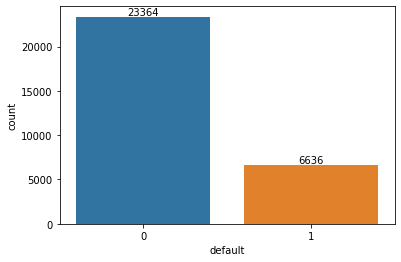

In [12]:
# See the target variable balance
ax = sns.countplot(x='default', data=df)
ax.bar_label(ax.containers[0])
plt.show()

In [13]:
# Class proportions in relative terms
df['default'].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default, dtype: float64

* We see that out of the 30,000 observations, only **6,636 or 22%**, are labelled as **default**. That is, out dataset is imbalanced.
* The imbalanced nature of the dataset, as well as the available remedies, are discussed later in the notebook.

**Gauge how features are related to each other**

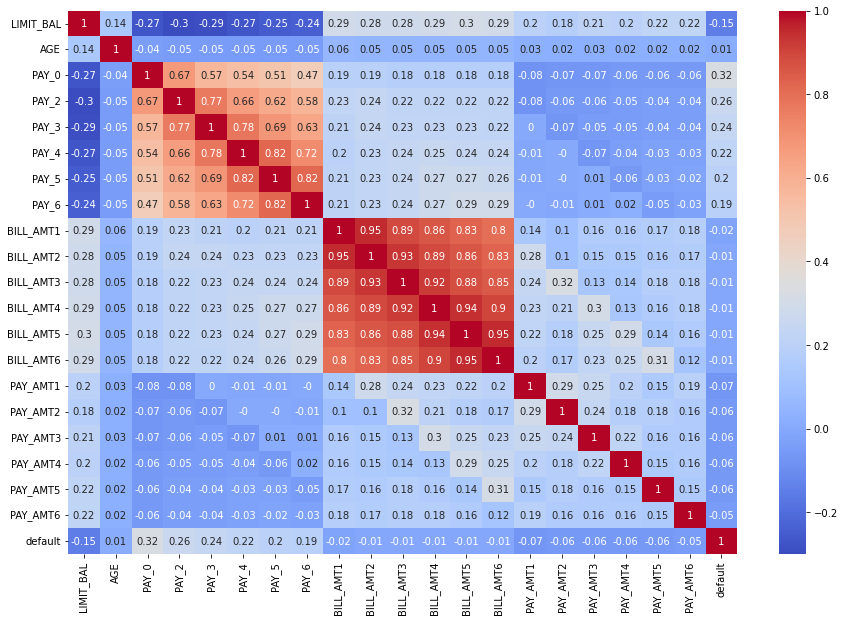

In [14]:
# Correlation table
plt.figure(figsize=(15,10))
sns.heatmap(
    df.corr().round(2), 
    annot=True,
    cmap='coolwarm'
    )
plt.show()

* Unsurprisingly, the table shows that **default** is most strongly (linearly) related to the past repayment status (**PAY_0** - **PAY_6**; whether repayment has been delayedd); the more the payment is delayed, the higher the probability of default. Moreover, intuitively, the recent delays are more important for default probability.

* As expected, I also find that the features in clusters **PAY0 - PAY6** and **BILL_AMT1 - BILL_AMT6** are strongly correlated with each other within the cluster. This raises the question whether we should drop some of the features to avoid the 'curse of dimensionality' (i.e., overfitting). However, we will let the L1 Logistic Regression deal with feature selection later on.

* In contrast, the past months' repayment amounts (**PAY_AMT1 - PAY_AMT6**) are not particularly strongly correlated.

**Categorical features' distributions**

Plotting the distributions of the categorical features, and incorporate the default probability 

In [15]:
# Obtain categorical columns
cat_cols = [col for col in df.columns if df[col].dtype == 'O' and col != 'default']
cat_cols

['SEX', 'EDUCATION', 'MARRIAGE']

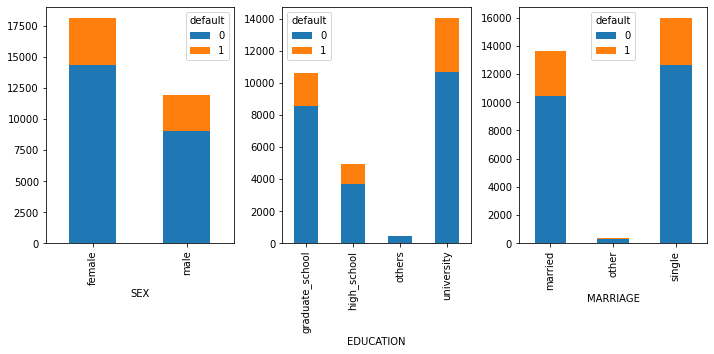

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
idx = 0
for col in cat_cols:
    pd.crosstab(df[col], df['default']).plot.bar(stacked=True, use_index=True, ax=ax[idx])
    idx += 1
plt.tight_layout(pad=1)

* While the categories are not particularly balanced, the default probabilities within categories seem relatively similar - that is, there does not seem to be any categories that stand out with a strikingly high default probability.



**Numerical features' distributions**

In [17]:
# Obtain numerical columns
num_cols = [col for col in df.columns if col not in cat_cols and col != 'default']

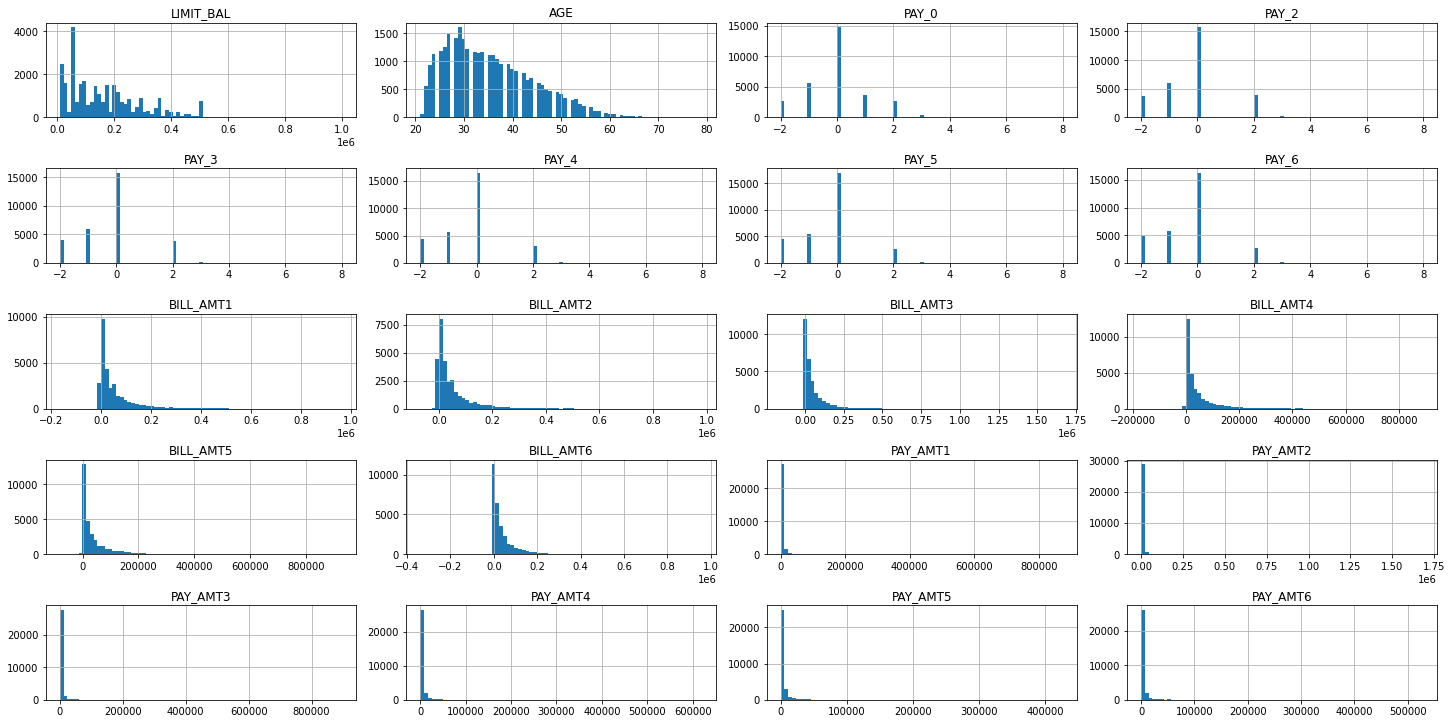

In [18]:
# Plot histograms of the numerical features (PAY_N features are discrete but their values have a numerical interpretation)
df[num_cols].hist(bins=75, figsize=(20, 10))
plt.tight_layout(pad=0.5)

* We see that the distributions of several features are extremely skewed. This is a result of the dataset containing individuals with extremely high consumption habits - i.e., rich people.

* The non-normality would be an issue if we were to train a neural net, but decision tree-based classifiers - which RF, XGB, and LGBM all are - are not sensitive to outliers. This is because trees do not fit on single datapoints similarly as OLS or neural nets for instance, but rather bin them.

* If we wanted to deal with outliers  (which we do want later in the notebook when working with neural nets), we could
     * transform the features with log or square root to mitigate skewness
     * either MixMax- or Standard-scale the features a similar range
     * potentially remove singular observations

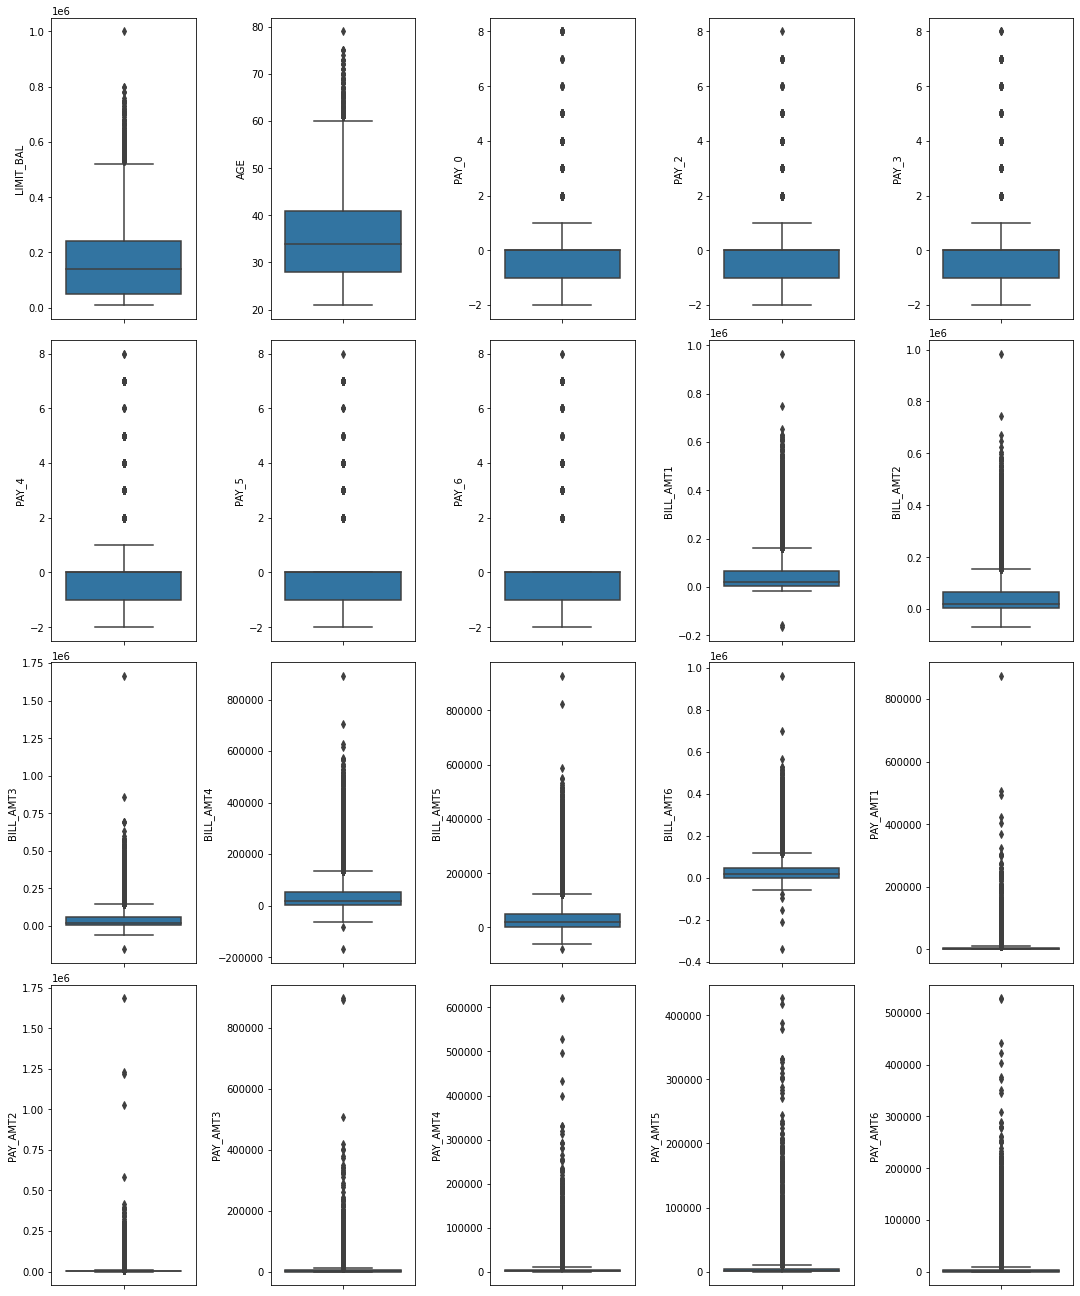

In [19]:
# Create boxplots to gauge outliers in more detail
fig, ax = plt.subplots(ncols=5, nrows=4, figsize=(15,18))
idx = 0
ax = ax.flatten()
for col, val in df[num_cols].items():
    sns.boxplot(y=col, data=df, ax=ax[idx])
    idx += 1
plt.tight_layout(pad=0.7)

# **Preprocessing**

In this part, I
* One-hot encode categorical variables. This means turning, e.g., the SEX column with male and female entries into a set of dummy variables.
* Split dataframe into X and y training and test sets

In [20]:
# Create dictionary of three-character prefixes for each categorical columns that will be one-hot encoded
prefixes = [col[:3] for col in cat_cols]
prefix_dict = {k:v for k,v in zip(cat_cols, prefixes)}
prefix_dict

{'SEX': 'SEX', 'EDUCATION': 'EDU', 'MARRIAGE': 'MAR'}

In [21]:
# Function for one-hot encoding categorical variables
def one_hot_encode(df, prefix_dict):
    df = df.copy()
    for col, prefix in prefix_dict.items():
        dummies = pd.get_dummies(df[col], prefix)
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1, inplace=True)
    
    return df

In [22]:
# Perform one-hot encoding of categorical variables
df = one_hot_encode(df, prefix_dict)
df.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default', 'SEX_female', 'SEX_male',
       'EDU_graduate_school', 'EDU_high_school', 'EDU_others',
       'EDU_university', 'MAR_married', 'MAR_other', 'MAR_single'],
      dtype='object')

In [23]:
# Remove columns whose information is already encoded in the remaining variables
# E.g., when SEX_male == 1, it is always true that SEX_female == 0, and vice versa
# Hence, to avoid reduce excess dimensionality which may hinder learning, I remove these redundant columns
df = df.drop(['SEX_female', 'EDU_others', 'MAR_other'], axis=1)

In [94]:
# Split data into X (features) and y (target)
X, y = df.drop(['default'], axis=1), df['default'].values
X.shape, y.shape

((30000, 26), (30000,))

In [95]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=manual_seed)

* It's favorable to use a **stratified split** due to the imbalance in target variable. Stratrification ensures a similar target variable distribution in both train and test sets

# **Pipelines and Hyperparameter optimization by Randomized Search**

In this section, I define the used classifiers and the data pipelines, as well as perform hyperparameter optimization. 

As noted earlier, the tested classifiers include Random Forest, XGBoost, and LightGBM classifiers. In the data pipeline preceding the classifier comes an L1 Logistic Regression-based feature selector, which potentially reduces data dimensionality in order to avoid overfitting.

Naturally, the behaviors of the feature selector as well as the classifier are highly dependent on the hyperparameters they are given. However, due to the vast number of hyperparameters available, finding an optimal combination by hand is often a daunting task. Hence, we give that task to the computer to solve. What we have to define manually is only the parameter space that the algorithm searches. 

The main reason for working with a pipeline here is that it easily allows to find the set of hyperparameters that maximizes the performance of the entire pipeline, not just the classifier alone. This means we can optimize the dimensionality reduction and classification problems as a single entity. For instance, if some of the classifier works better with a trimmed down feature set, whereas another classifier requires the full dataset, this approach allows both classifiers to function optimally.

There exist a plethora of different optimization algorithms, but in here, I use a basic **Randomized Search**. At each iteration, the algorithm simply samples a random combination of hyperparameters from the defined hyperparameter space, and fits the model. While the approach may seem naive, it produces results surprisingly comparable to more "intelligent" algorithms on the condition we let the algorithm perform sufficiently many iterations.

**Counteracting the effect of imbalanced data**

As shown previously, our dataset is imbalanced. Often, this class imbalance results in suboptimal learning outcomes, and the model performance can be improved easily by balancing the dataset. 

A typical - and better - approach for making class proportions equal is to oversample the minority class rather than discarding data from the majority class. Often, this is carried out with *Synthetic Minority Oversampling TEchnique* or SMOTE, for short. In short, SMOTE relies on a K-Nearest Neighbor algorithm in creating synthetic minority class samples that have similar characteristics as the actual minority class samples. Interestingly, however, in unreported tests, I find that I attain a better validation performance by *not* using SMOTE. Hence, I do not include SMOTE in the pipeline below.

Another possible way to overcome the negative effects imbalanced data imposes on learning is to use *class weights* which are different for the minority and majority classes. The difference in weights will influence the classification of the classes during the training phase. The purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class. I find success with this approach, compared to not adjusting for class imbalance at all. Hence, all reported results below, both with tree-based classifiers as well as the neural net use class weights.

**Stratified k-Fold Cross-Validation**

I use k-Fold Cross-Validation with k=5 in the hyperparameter search, meaning each training epoch is split into five folds. The core idea of a regular kFCV is to use each data point both, for training and validating the model. This should avoid overfitting, and prevents biases in performance evaluation.

In the first fold, reserve the first fifth of the data for validation, and train the model on the rest. Then, in the second fold, we use the second fifth of the data for validation, and train the model on the rest - including the first fold's validaton data. This process is repeated k=5 times so that all data points have been used once for validation, and four times for training.

A slight modification to the conventional kFCV is stratification which is necessary when working with imbalanced datasets. Stratification ensures each of the folds have an equal distribution of outcome observations (i.e., defaults and timely payments), preventing situations in which a fold would consist entirely of a single class.

**Metric used in ranking the models**

Obviously, if one optimizes something, he or she has to decide the variable, or metric, that should be either maximized or minimized. There are several options available. Let's start by laying out the standard model evaluation metrics:

* **Accuracy**: The proportion of predictions that are correct
* **Recall**: The proportion of positive labels that were correctly predicted
* **Precision**: The proportion of positive predictions that are correct
* **F1 Score**: (2 x recall x precision)/(recall + precision) , takes into account both recall *and* precision simultaneously.
* **ROC-AUC**: The area under a curve spanning an xy-plane, where x (y) is false (true) positive rate.

In this application, the intuitive interpreatation of the metrics is

* **Accuracy**: How often does model predict correctly defaulters and non-defaulters
* **Recall**: What fraction of defaulters does the model catch
* **Precision**: What fraction of the predicted defaulters actually default
* **F1 Score**: -
* **ROC-AUC**: -

Which of the metrics should be used? Let us remind ourselves of the use case of the model; identifying people at risk of default in the near future so we can approach them and make special arrangements in order to avoid the expenses of debt collection. Now, considering the use case, **it is arguably more important to catch as many defaulters as possible, and run the risk of classifying some non-defaulters incorrectly as defaulters, than the other way around**. In other words, we want to primarily avoid false negatives. Thus, the most suitable metric for our purposes would be recall.

However, as I'll show later in the notebook, the classification threshold of a trained model can altered, and doing so, one can obtain almost any level of recall or precision, at the expense of the other one deteriorating. Thus, it is perhaps not in our best interest to blindly maximize recall even if it captures the most important aspect of this exercise. Instead, a better approach is to maximize the overall performance of the model, and then adjust the classification threshold to obtain a desired recall. 

While accuracy can be thought of as representing the overall performance of a model it should be avoided when dealing with imbalanced datasets. This is because it's easy to attain a high accuracy only by always predicting the majority class, regardless of the features of the observation. For instance, as 78% of the observations in this datasets are non-defaults, a totally unintelligent model could get a 78% accuracy by always blindly predicting the negative class. However, doing so, the model would catch exactly zero defaults, and hence, be entirely useless.

In contrast, the **F1 score and AUC are more suitable for assessing the model's overall performance when the underlying data is imbalanced**. Similar to accuracy, both metrics range from 0 to 1, with higher values implying higher performance. The robustness of F1 derives from that it takes into the model’s ability over two attributes. AUC, in turn, provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. **Here, I will rank the classifiers' hyperparameter configurations based primarily on AUC**. Later in the notebook, I will adjust the classification thresholds to fix the recall rate of all models at 80%.

In [96]:
# Set up the k-fold stratified cross-validation (to be used within randomized search for model evaluation)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=manual_seed)

In [97]:
# Set up the L1 Logistic Regression
sel = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'), threshold='1e-7*mean')

In [98]:
# Define fixed XGBoost parameters
xgb_tree_method = 'gpu_hist' if torch.cuda.is_available() else 'hist' # Use histogram tree construction method, and with GPU support if GPU is available
xgb_balancing_factor = (y==0).sum() / (y==1).sum() # Scale positive weights by this amount, in order to counteract the impact of unbalanced data

In [99]:
# Define classifier models and hyperparameter space
grid = {
    RandomForestClassifier(
        random_state=manual_seed, class_weight='balanced'
    ):
    {'clf__n_estimators': np.arange(100,500,100),               # Number of trees in the forest
     'clf__max_depth': [4,6,8,10,12,14],                        # Maximum allowed tree depth
     'clf__min_samples_leaf': [1, 5, 10, 20],                   # Minimum number of samples required to be at a leaf node.
     'clf__criterion': ['gini', 'entropy'],                     # Method for computing information gain
     'sel__estimator__C': [0.0005, 0.0007, 0.001, 0.005, 0.01, 0.1, 1]}, # Regularization hyperparameter for feature selection with L1 LR (smaller values regularize)

    XGBClassifier(
        tree_method=xgb_tree_method, seed=manual_seed, scale_pos_weight=xgb_balancing_factor
    ):  
    {'clf__n_estimators': np.arange(100,500,100),               # Number of trees constructed iteratively
     'clf__max_depth': [4,6,8,10,12,14],                          
     'clf__subsample': [0.6, 0.8, 1.0],                         # Fraction of rows used when constructing each tree (smaller values regularize)       
     'clf__colsample_bytree': [0.6, 0.7, 0.8, 1.0],             # Fraction of columns used when constructing each tree (smaller values regularize)
     'clf__min_child_weight': [0.1, 0.5, 1, 2, 3],
     'clf__lambda': [0.001, 0.01, 0.1, 1, 10],                  # L2 regularization term on weights (larger values regularize)
     'clf__gamma': [0.001, 0.01, 0.1, 1, 10],                   # Minimum loss reduction required to make a further partition on a leaf node of the tree
     'clf__learning_rate': [0.005, 0.01, 0.1, 0.2, 0.3],
     'sel__estimator__C': [0.0005, 0.0007, 0.001, 0.005, 0.01, 0.1, 1]},

    LGBMClassifier(
        random_state=manual_seed, bagging_seed=manual_seed, objective='binary', is_unbalance=True
    ):
    {'clf__n_estimators': np.arange(100,500,100),               
     'clf__max_depth': [4,6,8,10,12,14],
     'clf__subsample': [0.6, 0.8, 1.0],
     'clf__colsample_bytree': [0.6, 0.7, 0.8, 1.0], 
     'clf__min_child_weight': [0.1, 0.5, 1, 2, 3],
     'clf__reg_lambda': [0.01, 0.1, 0.5, 1],
     'clf__learning_rate': [0.005, 0.01, 0.1, 0.2, 0.3],
     'sel__estimator__C': [0.0005, 0.0007, 0.001, 0.005, 0.01, 0.1, 1]}
}

In [100]:
def search(grid, n_iter):
    '''Wrapper for randomized search'''

    all_algos = pd.DataFrame()
    best_algos = {}

    # Loop through the classifiers and the associated parameter spaces
    for clf, params in grid.items():

        algo_name = str(clf).split('(')[0] 
        print(f'=== {algo_name} ===')
        t = time.time()

        # Create pipeline for the K-Best Features selector and classifier
        pipe = Pipeline([
            ('sel', sel),    
            ('clf', clf)
        ])

        # Perform randomized search on the parameter space
        model = RandomizedSearchCV(estimator=pipe, 
                                   param_distributions=params,
                                   scoring=['accuracy', 'recall', 'precision', 'f1', 'roc_auc'], # Set of metrics to track
                                   refit='roc_auc', # Metric on which the model is primarily evaluated at each iteration
                                   cv=kfold,                    
                                   n_jobs=-1,
                                   n_iter=n_iter, # Number of random hyperparameter combinations sampled and tested (for each classifier)
                                   verbose=1, 
                                   random_state=manual_seed)

        model.fit(X_train, y_train)

        # Get all results
        all_res = pd.DataFrame(model.cv_results_)

        # Select desired results
        res = all_res.loc[:, ['params', 'mean_test_accuracy', 'mean_test_recall', 'mean_test_precision', 'mean_test_f1', 'mean_test_roc_auc']]

        # Obtain algorithm name
        res['algo_name'] = algo_name

        # Append resuls
        all_algos = pd.concat([all_algos, res], ignore_index=True)
        best_algos[algo_name] = model.best_estimator_

        t = time.time() - t
        print(f'=== Finished (elapsed seconds: {t:.1f} in total, {(t/(5*n_iter)):.2f} per fit) ===\n')

    return all_algos, best_algos

**Perform Random Search**

*Kindly notice, that the errors in the cell output are non-critical. They dervie from the precision score (one of the tracked metrics) being ill-defined in cases where the sum of true and false positives (i.e., the denominator in the precision calculation) is zero. These cases are replaced with zero.*

In [101]:
all_algos, best_algos = search(grid, n_iter=75)

=== RandomForestClassifier ===
Fitting 5 folds for each of 75 candidates, totalling 375 fits
=== Finished (elapsed seconds: 486.9 in total, 1.30 per fit) ===

=== XGBClassifier ===
Fitting 5 folds for each of 75 candidates, totalling 375 fits
=== Finished (elapsed seconds: 1757.2 in total, 4.69 per fit) ===

=== LGBMClassifier ===
Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined a

=== Finished (elapsed seconds: 79.0 in total, 0.21 per fit) ===



In [102]:
# Show top 10 algorithms from best to worst, sorted on ROC-AUC score
pd.set_option('display.max_colwidth', None)
all_algos.sort_values('mean_test_roc_auc', ascending=False).iloc[:10,:].reset_index(drop=True)

,params,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,algo_name
0,"{'sel__estimator__C': 1, 'clf__subsample': 0.8, 'clf__n_estimators': 300, 'clf__min_child_weight': 3, 'clf__max_depth': 6, 'clf__learning_rate': 0.01, 'clf__lambda': 1, 'clf__gamma': 1, 'clf__colsample_bytree': 0.6}",0.765250,0.620265,0.476556,0.538955,0.783006,XGBClassifier
1,"{'sel__estimator__C': 0.1, 'clf__subsample': 0.6, 'clf__reg_lambda': 0.5, 'clf__n_estimators': 400, 'clf__min_child_weight': 3, 'clf__max_depth': 4, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.6}",0.762500,0.625725,0.472180,0.538191,0.782576,LGBMClassifier
2,"{'sel__estimator__C': 0.005, 'clf__subsample': 1.0, 'clf__reg_lambda': 0.5, 'clf__n_estimators': 200, 'clf__min_child_weight': 0.1, 'clf__max_depth': 14, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.8}",0.782333,0.585417,0.506886,0.543308,0.781981,LGBMClassifier
3,"{'sel__estimator__C': 0.1, 'clf__n_estimators': 300, 'clf__min_samples_leaf': 20, 'clf__max_depth': 14, 'clf__criterion': 'entropy'}",0.780292,0.593329,0.502863,0.544346,0.781948,RandomForestClassifier
4,"{'sel__estimator__C': 0.01, 'clf__subsample': 1.0, 'clf__reg_lambda': 0.5, 'clf__n_estimators': 400, 'clf__min_child_weight': 1, 'clf__max_depth': 12, 'clf__learning_rate': 0.005, 'clf__colsample_bytree': 0.8}",0.782875,0.588619,0.507922,0.545274,0.781821,LGBMClassifier
5,"{'sel__estimator__C': 0.005, 'clf__subsample': 0.6, 'clf__reg_lambda': 0.1, 'clf__n_estimators': 300, 'clf__min_child_weight': 2, 'clf__max_depth': 6, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.7}",0.770583,0.608209,0.485192,0.539742,0.781802,LGBMClassifier
6,"{'sel__estimator__C': 0.005, 'clf__n_estimators': 400, 'clf__min_samples_leaf': 20, 'clf__max_depth': 14, 'clf__criterion': 'gini'}",0.779958,0.591447,0.502264,0.543210,0.781587,RandomForestClassifier
7,"{'sel__estimator__C': 0.005, 'clf__n_estimators': 400, 'clf__min_samples_leaf': 20, 'clf__max_depth': 14, 'clf__criterion': 'entropy'}",0.780625,0.591447,0.503543,0.543960,0.781475,RandomForestClassifier
8,"{'sel__estimator__C': 1, 'clf__subsample': 0.6, 'clf__reg_lambda': 0.5, 'clf__n_estimators': 100, 'clf__min_child_weight': 0.1, 'clf__max_depth': 4, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.7}",0.759958,0.631001,0.468478,0.537651,0.781370,LGBMClassifier
9,"{'sel__estimator__C': 0.1, 'clf__subsample': 0.6, 'clf__n_estimators': 100, 'clf__min_child_weight': 0.1, 'clf__max_depth': 14, 'clf__learning_rate': 0.01, 'clf__lambda': 1, 'clf__gamma': 10, 'clf__colsample_bytree': 0.8}",0.769417,0.609340,0.483231,0.538985,0.781284,XGBClassifier


In [103]:
# Show best hyperparameter set for each classifier type
best_algos

{'RandomForestClassifier': Pipeline(steps=[('sel',
                  SelectFromModel(estimator=LogisticRegression(C=0.1,
                                                               penalty='l1',
                                                               solver='liblinear'),
                                  threshold='1e-7*mean')),
                 ('clf',
                  RandomForestClassifier(class_weight='balanced',
                                         criterion='entropy', max_depth=14,
                                         min_samples_leaf=20, n_estimators=300,
                                         random_state=0))]),
 'XGBClassifier': Pipeline(steps=[('sel',
                  SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                                               solver='liblinear'),
                                  threshold='1e-7*mean')),
                 ('clf',
                  XGBClassifier(base_score=0.5, booster='gb

# **Training the best models**

Using the best hyperparameters from the optimization routine, in this section, I train one classifier of each type. As the pipeline of each classifier may differ in the feature selection part, I run the training data through the feature selector first (with the optimal hyperparameters), and create separate train and test feature sets for each classifiers. Then, I perform training of the classifiers.


**Fit selectors and perform transformation**

In [104]:
def fit_transform_selectors(best_algos, X_train, X_test):
    X_set = {} # Container for each classifier's transformed X_train and X_test sets
    
    for clf_name in best_algos:
        
        # Obtain the best feature selector for the classifier
        sel = best_algos[clf_name]['sel']

        # Fit
        sel.fit(X_train, y_train)

        # Transform feature sets (i.e., select best features)
        X_train_tf = sel.transform(X_train)
        X_train_tf = pd.DataFrame(X_train_tf, columns=sel.get_feature_names_out())

        X_test_tf = sel.transform(X_test)
        X_test_tf = pd.DataFrame(X_test_tf, columns=sel.get_feature_names_out())

        # Append data
        X_set[clf_name] = {'X_train': X_train_tf, 'X_test': X_test_tf}

    return X_set

In [105]:
X_set = fit_transform_selectors(best_algos, X_train, X_test)

**Train the best version of each classifier type**

In [106]:
def train_classifiers(best_algos, X_set, y_train):
    trained_clfs = {}

    for clf_name in best_algos:
        
        # Obtain best classifier
        clf = best_algos[clf_name]['clf']

        # Train the best classifier with the transformed feature dataset
        clf.fit(X_set[clf_name]['X_train'], y_train)

        # Append the trained classifier to dictionary
        trained_clfs[clf_name] = clf
  
    return trained_clfs

In [107]:
trained_clfs = train_classifiers(best_algos, X_set, y_train)
trained_clfs

{'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', criterion='entropy',
                        max_depth=14, min_samples_leaf=20, n_estimators=300,
                        random_state=0),
 'XGBClassifier': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=1, gpu_id=0, grow_policy='depthwise',
               importance_type=None, interaction_constraints='', lambda=1,
               learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=3,
               missing=nan, monotone_constraints='()', n_estimators=300,
               n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, ...),
 'LGBMClassifier': LGBMClassifier(bagging_seed=0, colsample_bytree=0.

**Create predictions with each classifier**

In [108]:
def predict(trained_clfs, X_set, use_test_set=True):
    set_name = 'X_test' if use_test_set else 'X_train'
    preds_dict = {}

    for clf_name, clf in trained_clfs.items():
         
         # Output binary prediction
         preds = clf.predict(X_set[clf_name][set_name])

         # Output classification probability
         preds_proba = clf.predict_proba(X_set[clf_name][set_name])

         preds_dict[clf_name] = {'preds_binary': preds, 'preds_proba': preds_proba[:,1]}

    return preds_dict

In [135]:
# Test set predictions
preds = predict(trained_clfs, X_set, use_test_set=True)

In [136]:
# Train set predictions (will be used for assessing overfitting)
train_preds = predict(trained_clfs, X_set, use_test_set=False)

**Create summary of each classifier's performance on test set**

In [137]:
# Compute metrics for all classifiers
def get_metrics(preds, labels, thresholds=None):

    if thresholds is None:
        thresholds = {clf_name:0.5 for clf_name in best_algos}

    # Empty container for recorded metrics
    names = [clf_name for clf_name in best_algos]
    names.insert(0, 'NULL')
    metrics = pd.DataFrame(index=names, columns=['accuracy', 'recall', 'precision', 'f1_score'])
    
    # Null model stats
    null_preds = np.repeat(pd.DataFrame(labels).value_counts().idxmax(), len(labels)) # Always predict majority class
    metrics.loc['NULL', 'accuracy'] = accuracy_score(labels, null_preds).round(4)
    metrics.loc['NULL', 'recall'] = recall_score(labels, null_preds, zero_division=0).round(4)
    metrics.loc['NULL', 'precision'] = precision_score(labels, null_preds, zero_division=0).round(4)
    metrics.loc['NULL', 'f1_score'] = f1_score(labels, null_preds, zero_division=0).round(4)
    metrics.loc['NULL', 'roc_auc'] = roc_auc_score(labels, null_preds).round(4)

    for clf_name, clf_preds in preds.items():
        
        # Obtain predicted probabilities for class 1
        preds_proba = clf_preds['preds_proba']

        # Turn into binary predictions
        preds_binary = [1 if pred_proba >= thresholds[clf_name] else 0 for pred_proba in preds_proba]

        # Compute metrics
        metrics.loc[clf_name, 'accuracy'] = accuracy_score(labels, preds_binary).round(4)
        metrics.loc[clf_name, 'recall'] = recall_score(labels, preds_binary).round(4)
        metrics.loc[clf_name, 'precision'] = precision_score(labels, preds_binary).round(4)
        metrics.loc[clf_name, 'f1_score'] = f1_score(labels, preds_binary).round(4)
        metrics.loc[clf_name, 'roc_auc'] = roc_auc_score(labels, preds_binary).round(4)
    
    return metrics

In [138]:
# Test set metrics
metrics = get_metrics(preds, y_test)
metrics

,accuracy,recall,precision,f1_score,roc_auc
NULL,0.7788,0.0,0.0,0.0,0.5000
RandomForestClassifier,0.7777,0.5938,0.4978,0.5416,0.7118
XGBClassifier,0.7607,0.624,0.4691,0.5356,0.7117
LGBMClassifier,0.7613,0.6255,0.4703,0.5369,0.7127


* Overall, all classifiers score relatively close to one another measured on F1 Scores or ROC AUC.

* Interestingly, measured with the F1 Score, **Random Forest seems to have the best overall performance**. In general one would expect the other two, more sophisticated models, to perform better.

* While the Random Forest has a lower recall than the other two models, which might, at first blush, make it seem suboptimal for our purposes, we can try and fix that in the next section by changing the classification threshold. Thus in this phase, the overall performance, measured with F1 or AUC is arguably more important.

In [139]:
# Train set metrics
train_metrics = get_metrics(train_preds, y_train)
train_metrics

,accuracy,recall,precision,f1_score,roc_auc
NULL,0.7788,0.0,0.0,0.0,0.5000
RandomForestClassifier,0.8079,0.6715,0.5543,0.6073,0.7591
XGBClassifier,0.7833,0.6674,0.5077,0.5767,0.7418
LGBMClassifier,0.7697,0.6495,0.4847,0.5551,0.7267


* Expectedly, all models performed better in the train set than in the test set to some degree.

* **Random Forest seems to overfit the most**, and XGBoost the least. This makes it even more surprising that Random Forest performed the best in the test set, and XGBoost the worst. In general, one would expect a model that overfits to generalize poorly to unseen data. 

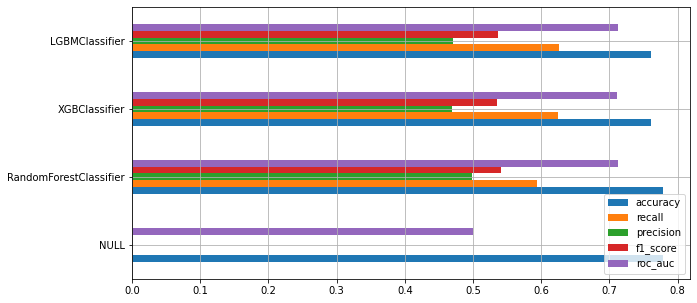

In [140]:
# Plotting the performance metrics on TEST data
fig, ax = plt.subplots(figsize=(10,5))
metrics.plot(kind='barh', ax=ax, grid=True)
plt.show()

# **Adjusting model performance by changing the classification threshold**

While a 60% recall rate may be sufficient for some instances, a bank would likely prefer to identify a larger proportion of the future defaulters. Luckily, we're not out of luck.

Under the hood, the predictions made by the models are not *fundamentally* binary in their nature. Rahter, the models ouput a probability for each sample, which is then classified as a one or a zero. By default, the classification threshold is 0.5: when a probability is higher (lower) than that, the sample is classified as a default (non-default). 

However, one may tinker with this threshold and thereby adjust the perofrmance of the model. If the threshold is lowered, the classifier becomes "more sensitive" (i.e, classifies an observation as default more easily), which is exactly what we need in order to increase the recall. However, this will inevitably come at the expense of precision and accuracy.

Below, **I set the desired level of recall at 80%** (i.e., I expect the model to capture 80% of all defaults), **and study how the performance changes**, and whether model ranking changes with these changes made.

**Precision recall curve**

A precision recall curve depicts the possible combinations of precision and recall a model can attain at different classification threshold levels. The better the model, the higher the curve is located on the graph, and the more concave the shape is.

In [141]:
pre_rec_th_dict = {}
for clf_name in best_algos:
    pre, rec, th = precision_recall_curve(y_test, preds[clf_name]['preds_proba'])
    pre_rec_th_dict[clf_name] =  {'precision': pre, 'recall': rec, 'threshold': th}

In [142]:
pre_RF, rec_RF = pre_rec_th_dict['RandomForestClassifier']['precision'], pre_rec_th_dict['RandomForestClassifier']['recall']
pre_XG, rec_XG = pre_rec_th_dict['XGBClassifier']['precision'], pre_rec_th_dict['XGBClassifier']['recall']
pre_LG, rec_LG = pre_rec_th_dict['LGBMClassifier']['precision'], pre_rec_th_dict['LGBMClassifier']['recall']

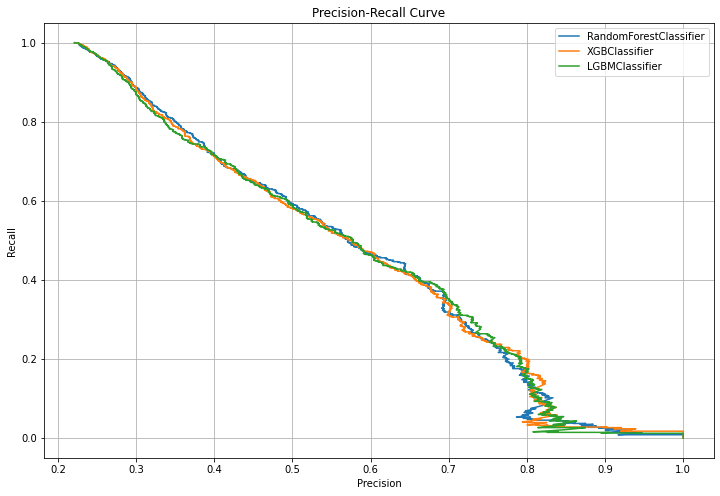

In [143]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(pre_RF, rec_RF, label='RandomForestClassifier')
ax.plot(pre_XG, rec_XG, label='XGBClassifier')
ax.plot(pre_LG, rec_LG, label='LGBMClassifier')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.legend()
ax.grid()

* The precision-recall curve reveals how close the models' performances actually are. **None of the models is clearly and inherently better than the others** at any level of recall that is suitable for our purposes.

* However, it seems that **at 80% recall rate, the Random Forest is able to provide a marginally higher precision than either of the other two classifiers.**

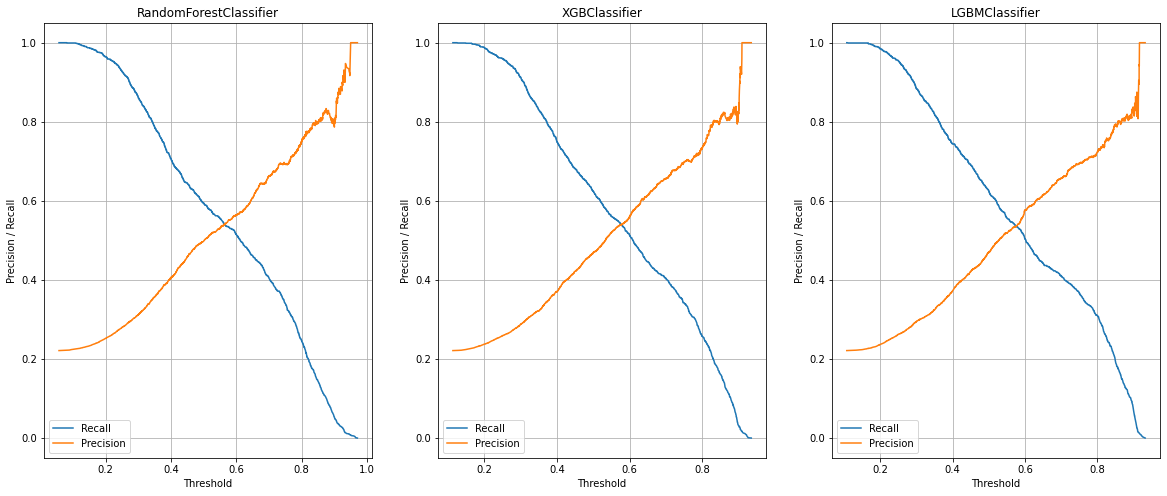

In [144]:
# Plotting the recall and precision for each classifier separately
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
idx = 0
for clf_name, vars in pre_rec_th_dict.items():
    ax[idx].plot(vars['threshold'], vars['recall'][1:,], label='Recall')
    ax[idx].plot(vars['threshold'], vars['precision'][1:,], label='Precision')
    ax[idx].set_xlabel('Threshold')
    ax[idx].set_ylabel('Precision / Recall')
    ax[idx].set_title(clf_name)
    ax[idx].legend()
    ax[idx].grid()
    idx += 1

**Finding the threshold corresponding to a 80% recall**

In [145]:
# Get threshold values for a certain level of recall
def closest_value_idx(input_list, value):
    arr = np.asarray(input_list)
    return (np.abs(arr - value)).argmin()
    
def get_thresholds(pre_rec_th_dict, recall):
    th_dict = {}
    for clf_name, vars in pre_rec_th_dict.items():
        idx = closest_value_idx(vars['recall'][1:], recall)
        th_dict[clf_name] = vars['threshold'][idx]
    
    return th_dict

In [146]:
th_dict = get_thresholds(pre_rec_th_dict, 0.8)
th_dict

{'RandomForestClassifier': 0.3418789708552852,
 'XGBClassifier': 0.37131068,
 'LGBMClassifier': 0.36130586363457995}

**Performance metrics with recall fixed at 80%**

In [147]:
# Get metrics for the new, desired recall level
metrics_adj = get_metrics(preds, y_test, th_dict)
metrics_adj

,accuracy,recall,precision,f1_score,roc_auc
NULL,0.7788,0.0,0.0,0.0,0.5000
RandomForestClassifier,0.6272,0.8011,0.3501,0.4873,0.6894
XGBClassifier,0.6195,0.8011,0.3449,0.4822,0.6845
LGBMClassifier,0.6058,0.8011,0.336,0.4734,0.6757


* As expected on the basis of the precision-recall curve, the performance differences are not massive, when recall is fixed at the 80% level.

* However, as also expected on the basis of the precision-recall curve, **Random Forest performs better than the other two classifiers.** It's precision is 0.5 %-points higher than that of the XGBoost, and up to 1.4 %-points higher than that of the LGBM. This is naturally reflected in the higher F1, ROC AUC, and accuracy scores, as well. 

* Thus, **at this point in the investigation, the Random Forest Classifier is the recommended model for identifying defaults.**

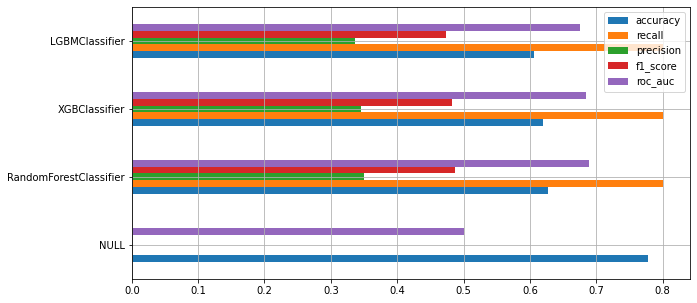

In [148]:
fig, ax = plt.subplots(figsize=(10,5))
metrics_adj.plot(kind='barh', ax=ax, grid=True)
plt.show()

# **Ensembling**

Ensembling is a popular way of building models, in which one trains a bunch of models (or "weak learners") simultaneously and aggregates their predictions as a single prediction. Indeed, even all of the models used here are Ensemble methods. Random Forest consists of several "parallel" decision trees, whose preidictions are aggregated as descirbed above. In contrast, gradient boosting methods, which both XGBoost and LightGBM belong to, involve many "successive" decision trees, each of which being fit on the residulas of the previous tree, and thereby improving on the prediction of the previous tree. 

However, in this section, I form a single classifier of these three classifiers (called stacking), and see whether this sort of ensembling brings any improvements in performance.

More specifically, I create two different types of Ensemble models:

1. I **average the predicted probabilities** of the three classifiers and use the resultant mean probability for classification

2. I use **majority voting**, i.e., the ensemble prediction is the class which is most predicted

In [149]:
# Get ensemble predictions
def ensemble_predict(preds):
    
    df = pd.DataFrame()
    for _, all_preds in preds.items():
        df = pd.concat([df, pd.Series(all_preds['preds_proba'])], axis=1)
    
    # Convert probabilities into predicted classes
    df_cls = df.round().astype('int')

    pred_dict = {
        'mean_proba': np.array(df.mean(axis=1)),
        'majority_vote': np.array(df_cls.mode(axis=1))
        }

    return pred_dict

In [150]:
ensemble_preds = ensemble_predict(preds)

In [151]:
# Add ensemble performance to metric dataframes
def add_to_metrics(preds_proba, name, metrics, threshold=0.5, include_majority_vote=False):
    
    # Turn into binary predictions
    preds_binary = [1 if pred_proba >= threshold else 0 for pred_proba in preds_proba]

    # Compute metrics
    metrics = metrics.copy()

    metrics.loc[name] = [
        accuracy_score(y_test, preds_binary).round(4),
        recall_score(y_test, preds_binary).round(4),
        precision_score(y_test, preds_binary).round(4),
        f1_score(y_test, preds_binary).round(4),
        roc_auc_score(y_test, preds_binary).round(4)
    ]

    if include_majority_vote:
        metrics.loc['EnsembleMajorityVote'] = [
            accuracy_score(y_test, ensemble_preds['majority_vote']).round(4),
            recall_score(y_test, ensemble_preds['majority_vote']).round(4),
            precision_score(y_test, ensemble_preds['majority_vote']).round(4),
            f1_score(y_test, ensemble_preds['majority_vote']).round(4),
            roc_auc_score(y_test, ensemble_preds['majority_vote']).round(4)
        ]

    return metrics

In [152]:
# Add basic ensemble metrics to the dataframe with standard 0.5 classification threshold
metrics_ens = add_to_metrics(ensemble_preds['mean_proba'], 'EnsembleMeanProba', metrics, include_majority_vote=True)
metrics_ens

,accuracy,recall,precision,f1_score,roc_auc
NULL,0.7788,0.0,0.0,0.0,0.5000
RandomForestClassifier,0.7777,0.5938,0.4978,0.5416,0.7118
XGBClassifier,0.7607,0.624,0.4691,0.5356,0.7117
LGBMClassifier,0.7613,0.6255,0.4703,0.5369,0.7127
EnsembleMeanProba,0.7692,0.6164,0.4829,0.5415,0.7145
EnsembleMajorityVote,0.7647,0.6187,0.4754,0.5377,0.7124


* At the default classification threshold level of 0.5, and measured on the F1 Score, neither Ensemble Model is able to beat the Random Forest. 

* While both Ensemble Models' AUC score is ever so slightly better than Random Forest's, the difference is so marginal that it is difficult to make any robust inferences solely based on that.

<AxesSubplot: >

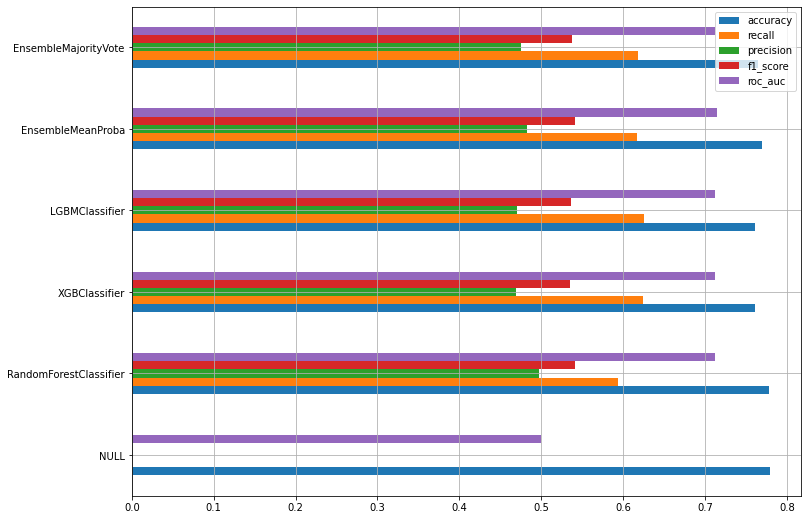

In [153]:
fig, ax = plt.subplots(figsize=(12,9))
metrics_ens.plot(kind='barh', ax=ax, grid=True)

**Adjusting classification threshold to get desired recall**

Similar to the underlying models, we can also adjust the performance of an Ensemble model by altering its classification threshold. For the mean probability-based classifier, the task is identical to what was done with the underlying models. 

However, for the majority voting-based classifier, the task is less straightforward. This is because we would have to alter the threshold of all three underlying classifiers separately. Preventing the notebook from becoming excessively long, I exclude adjusting the majority voting-based classifier from this investigation. Moreover, there are no signs of the majority voting-based classifier providing substantial improvements over the other models.

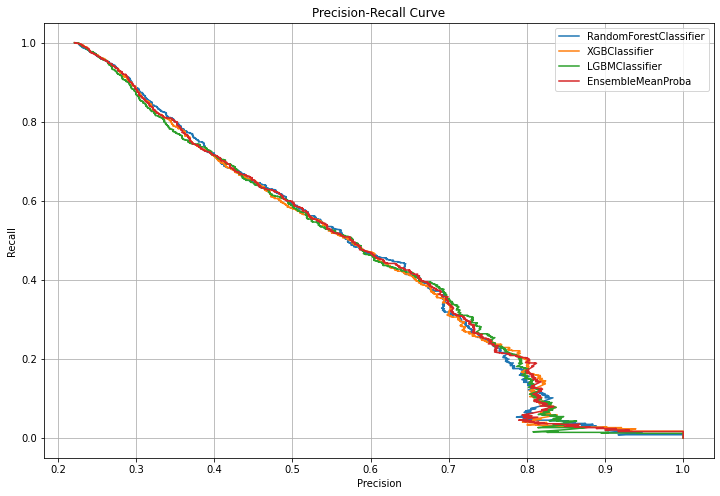

In [154]:
# Add Ensemble Classifier to the precision-recall curve figure
pre_EN, rec_EN, th_EN = precision_recall_curve(y_test, ensemble_preds['mean_proba'])

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(pre_RF, rec_RF, label='RandomForestClassifier')
ax.plot(pre_XG, rec_XG, label='XGBClassifier')
ax.plot(pre_LG, rec_LG, label='LGBMClassifier')
ax.plot(pre_EN, rec_EN, label='EnsembleMeanProba')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.legend()
ax.grid()

* Once again, the precision-recall curve illustrates how close the Ensemble Model is to the other two.

In [155]:
# Change threshold so that the 80% recall can be obtained
idx = closest_value_idx(rec_EN, 0.8)
th_adj = th_EN[idx]

In [156]:
# Add Ensemble metrics to the dataframe with adjusted classification thresholds
metrics_adj_ens = add_to_metrics(ensemble_preds['mean_proba'], 'EnsembleMeanProba', metrics_adj, th_adj, include_majority_vote=False)
metrics_adj_ens

,accuracy,recall,precision,f1_score,roc_auc
NULL,0.7788,0.0,0.0,0.0,0.5000
RandomForestClassifier,0.6272,0.8011,0.3501,0.4873,0.6894
XGBClassifier,0.6195,0.8011,0.3449,0.4822,0.6845
LGBMClassifier,0.6058,0.8011,0.336,0.4734,0.6757
EnsembleMeanProba,0.6255,0.8003,0.3489,0.4859,0.6881


* When the recall rate is fixed at 80% level, **the Random Forest has marginally better statistics than the Ensemble Model** (or the other two classifiers). However, the differences are minute. 

* Thus, it is difficult to give a clear, and unambiguous recommendation regarding which of the two models should be used. However, I would personally be more comfortable going with the Ensemble Model. 
    * First, it is likely that the model has to be retrained one day, and a stack of three models should be less sensitive to retraining than a single model.
    * Second, while the Random Forest performed best on unseen data, there was most evidence of overfitting for the Random Forest, which raises the question whether overfitting will ultimately become an issue when retrained in the future.
    * Third, Random Forest is the least sophisticated of the three classifiers, which makes me even more hesitant to use it over an ensemble. 
    

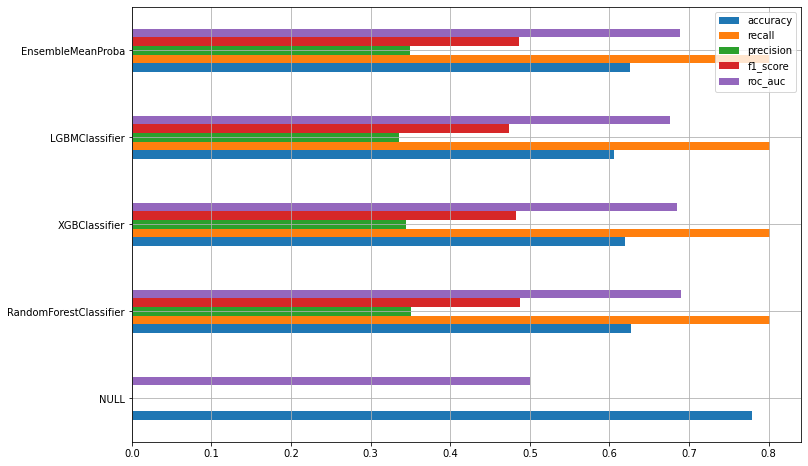

In [157]:
fig, ax = plt.subplots(figsize=(12,8))
metrics_adj_ens.plot(kind='barh', ax=ax, grid=True)
plt.show()

# **Feature Importances**

In this section, I gauge the **feature importances** of each of the three classifiers to understand more throughly which of the features play the most important role in predctions.

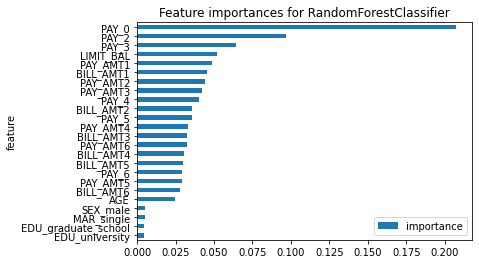

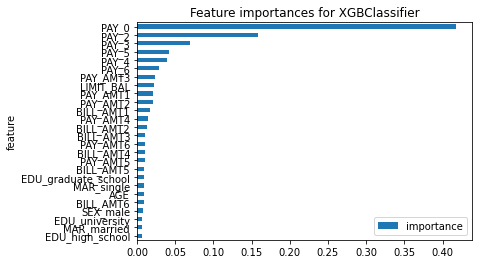

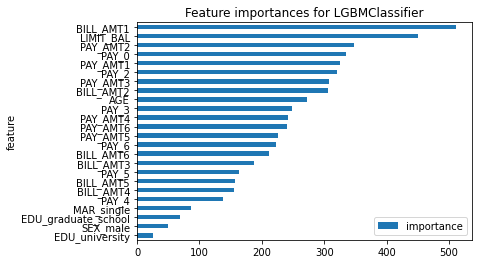

In [132]:
# Plot the feature importances for each classifier
for clf_name in best_algos:
    clf = trained_clfs[clf_name]
    features = X_set[clf_name]['X_train'].columns
    pd.DataFrame({'feature': features, 'importance': clf.feature_importances_}).\
      sort_values('importance', ascending=True).\
      plot('feature', 'importance', kind='barh', title=f'Feature importances for {clf_name}')

* The feature importances of Random Forest and XGBoost seem roughly as expected: the customer's payment status in the near history is clearly the most important feature, with importance decreasing with time. After that tend to come the customer's payment ad bill amounts, and then lastly, age, sex, or education don't appear to have any meaningful effect on the predictions.

* In contrast, the feature importance graph of the LGBM looks quite different. First, it's evident that none of the features have overwhelming importance, such as the PAY_0 feature in the case of the other two classifiers. Second, the payment status, payment amount and bill amount features are much more mixed and have more equal importances. Neither do importances seem to decrease with time as clearly as in the other two figures.

# **Neural Network Architecture**

As none of the decision tree-based classifiers provided mindblowingly great results, I also employ a Neural Network model to see whether it is capable of attaining more favorable performance.

The model is a simple Multi-Layer Perceptron (or Feedforward Neural Network) with batch normalization used in between the linear layers.

Similar to working with decision tree-based models, I optimize the choice of hyperparameters on validation data to ensure best possible performance on unseen test data.

In [26]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import optuna

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**Split data into test and train sets**

The train set will be split further into *actual* train set and validation set within the training loop. That is, the train data from the split below contain all data that will be used in the training phase (for training and validation), while the test data is saved for the very end.

In [28]:
# Split X and y into train and test data
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=manual_seed)

### **Trainer class**

The trainer class contains the functionality for training the model, and evaluating it on unseen validation data. 

**Flow of training**

* The data are iterated over multiple times, once every epoch. 

* Within each epoch, the data are split into 5 folds with stratification. Within each fold, the fold's data are split into train and validation sets. 

* Then, to mitigate the issue with extreme outliers, the one is able to trim the train set's tails at specified z-score level. This step is optional.

* Then, the to facilitate learning, the train set is scaled to a range from 0 to 1 with Min-Max Scaling, followed by a similar scaling for validation set using parameters from the train set (to avoid information leakages from validation to train set). 

* Then, to mitigate the issue with highly skewed distributions, I take a log transformation of all features. 

* The in the following step one is able to use SMOTE to balance the classes. As explained earlier, SMOTE oversamples the minority class by using a KNN algorithm to create synthetic samples. This step is optional.

* The last step before training and evaluation is moving the data into dataloaders. A dataloader is an iterable object that yields a batch of samples on each iteration. 

* Finally, the model is trained on the train set, and evaluated on the validation set. The fold's train and test metrics are recorded and saved.

* After this, the same procedure is carried out for the next fold. After iterating over the 5 folds, the epoch is over. At this point, epoch's metrics are computed as an arithmetic average of the five folds' metrics.

* Lastly, we move on the next epoch.

**Stratified k-Fold Cross-Validation**

As discussed above, I use k-Fold Cross-Validation with k=5 in training the model, meaning each training epoch is split into five folds. The core idea of a regular kFCV is to use each data point both, for training and validating the model. This should avoid overfitting, and prevents biases in performance evaluation.

In the first fold, reserve the first fifth of the data for validation, and train the model on the rest. Then, in the second fold, we use the second fifth of the data for validation, and train the model on the rest - including the first fold's validaton data. This process is repeated k=5 times so that all data points have been used once for validation, and four times for training.

A slight modification to the conventional kFCV is stratification which is necessary when working with imbalanced datasets. Stratification ensures each of the folds have an equal distribution of outcome observations (i.e., defaults and timely payments), preventing situations in which a fold would consist entirely of a single class.

**Data pre-processing within the training loop**

If data pre-processing is called *pre*-processing, then why do I carry it out mainly within the training loop. The reason lies mainly in the fact that I use Min-Max Scaling with kFCV.

First, one should understand that we must avoid at all cost any information leaking from validation (or test) set to the training set. Why? Because there's a good chance the model would capture that information in some way, and use it in the training procedure. In this case, the model would be partly fitted not only with the train data, but also on the validation data. In this case, any performance metrics computed with the validation data would be inflated and not represent the model's performance on unseen data; after all, the model *did* get to peek the validation data.

Now, when features are scaled with the Min-Max Scaler, we subtract from each datapoint the feature's minimum value, and divide the result by the features min-max range (i.e., the formula is `x - min(x)/(max(x)-min(x))`). If we did this process before splitting the data into the train and test sets, and a feature's min or max was not in the train, but in the test set, then the scaled data points in train set would contain test set information. To avoid this, we scale both sets with the train set's min and max values. 

And simply because we use kFCV, the train-test split is done within each epoch in the training loop - hence, we must perform the scaling procedure in the training loop. Notice, that because our data contains negative values, it's only after the Min-Max Scaling that we can take the log-transform of the features. SMOTE is also included in the training loop for the same reason as Min-Max Scaling; SMOTE requires fitting the model on training data, and doing it in an earlier phase would result in biased and inflated performance metrics.

**Parameters**

* **device**: Whether training takes place om CPU or GPU. A PyTorch device object.

* **X**: Matrix containing the features using which the prediction is made.

* **y**: Vector containing the labels.

* **model**: Model that is trained. Defined above.

* **epochs**: Number of epochs the model is trained. The training data is iterated over once every epoch.

* **batch_size**: Batch size. Number of training samples fed into the model simultaneously.

* **max_lr**: Maximum learning rate. Represents the maximum to which the learning rate scheduler will increse the LR over the training procedure.

* **grad_clip**: Value at which the gradients are clipped. For facilitating learning by avoiding extreme gradients.

* **weight_decay**: Multiplier for L2 regualrization in the loss function. A sum of squared weights, multiplied by weight_decay, is added to the loss. Prevents model being reliant on extreme weights, and hence, overfitting.

* **use_smote**: Whether or not the minority class should be upsampled with SMOTE. Boolean.

* **remove_outliers_zscore**: Z-score threshold for removing outliers in the training phase. Concerns PAY_AMT1-6 and BILL_AMT1-6 columns, which are the most skewed. For row to remain in the dataset, it must have Z-score below threhshold in all abovementioned columns. Set None for disabling outlier removal.

* **loss_func**: Loss function. Binary cross entropy is a standard choice for binary classification tasks. Loss = - p(x)log(q(x)) + (1-(p(x))log(1-q(x)) where p(x) is the probability of class x in target, and q(x) is the probability of class x in prediction.

* **opt_func**: Optimizer, i.e., the function that performs the calculation of algorithm that modifies the attributes of the neural network, such as weights and learning rate.

* **early_sop_patience**: Number of epochs after which training is stopped if a new minimum validation loss has not been reached. None to turn off early stopping.

* **print_every**: Performance output printed out every 'print_every'th epoch during training.

* **optimize**: Whether the trainer is used for hyperparameter optimization. True for optimization, False for actual training phase.

* **trial**: Optuna trial object. Required for hyperparameter optimization.

* **optimize_wrt**: The metric in validation phase which should be minimized/maximized in the hyperparameter optimization process.

In [36]:
class Trainer:

    def __init__(self, device, X, y, model, epochs, batch_size, max_lr, lr_gamma, lr_step_size, 
                 grad_clip, weight_decay=0, use_smote=False, remove_outliers_zscore=None,
                 loss_func=nn.BCEWithLogitsLoss(), opt_func=torch.optim.Adam, 
                 early_stop_patience=None, print_every=10,
                 optimize=False, trial=None, optimize_wrt='rec'):    
        
        torch.cuda.empty_cache()

        self.device = device
        self.X = X
        self.y = y
        self.model = model.to(device)
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.max_lr = max_lr
        self.grad_clip = grad_clip
        self.weight_decay = weight_decay

        self.use_smote = use_smote
        
        self.loss_func = loss_func
        self.opt_func = opt_func
        
        self.early_stop_patience = early_stop_patience
        self.best_valid_loss = np.inf
        self.epochs_since_new_best = 0
        
        self.print_every = print_every

        self.optimize = optimize
        self.optimize_wrt = optimize_wrt
        self.trial = trial

        self.remove_outliers_zscore = remove_outliers_zscore
        self.outlier_cols = [f'PAY_AMT{i}' for i in range(1,7)] + [f'BILL_AMT{i}' for i in range(1,7)] # Columns with outlier issues

        # Define optimizer
        self.optimizer = self.opt_func(model.parameters(), self.max_lr, weight_decay=self.weight_decay)
        
        # Define learning rate scheduler
        self.lr_sched = torch.optim.lr_scheduler.StepLR(self.optimizer, lr_step_size, lr_gamma)

        # Instantiate stratified k-Fold Cross-Validation
        self.kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=manual_seed)

        # Instantiate Min-Max Scaler
        self.scaler = MinMaxScaler()

        # Instantiate SMOTE
        self.smote = SMOTE(sampling_strategy='not majority', random_state=manual_seed)

        # Instantiate Sigmoid
        self.sigmoid = nn.Sigmoid().to(device)



    def fit(self):
        
        if not self.optimize:
            print('=== Starting training ===')

        torch.cuda.empty_cache()
        history = []

        for epoch in range(self.epochs):

            # Containers for storing folds' metrics
            fold_train_metrics_list = []
            fold_valid_metrics_list = []

            # Loop through K=5 folds
            for train_idx, valid_idx in self.kfold.split(self.X, self.y):

                # Assign current fold's train and valid data
                X_train, X_valid = self.X.iloc[train_idx,:], self.X.iloc[valid_idx,:]
                y_train, y_valid = self.y[train_idx], self.y[valid_idx]

                # Remove outliers
                if self.remove_outliers_zscore:
                    X_train, y_train = self.remove_outliers(X_train, y_train, self.remove_outliers_zscore)

                # Min-Max scale features
                X_train = self.scaler.fit_transform(X_train)
                X_valid = self.scaler.transform(X_valid)

                # Take log-transforms
                X_train = self.log_transform(X_train)                
                X_valid = self.log_transform(X_valid)

                # Oversample the training set with SMOTE
                if self.use_smote:
                    X_train, y_train = self.smote.fit_resample(X_train, y_train)

                # Move data into dataloaders (in batches)
                train_loader = self.get_dataloader(X_train, y_train, self.batch_size)
                valid_loader = self.get_dataloader(X_valid, y_valid, self.batch_size)

                # Train
                fold_train_metrics = self.train(train_loader)
                fold_train_metrics_list.append(fold_train_metrics)

                # Evaluate
                fold_valid_metrics = self.evaluate(valid_loader)
                fold_valid_metrics_list.append(fold_valid_metrics)

            # Get epoch metrics across (mean metrics across all folds)
            epoch_train_metrics = self.get_epoch_metrics(fold_train_metrics_list)
            epoch_valid_metrics = self.get_epoch_metrics(fold_valid_metrics_list)

            # Append history
            d = {
                 'fold_metrics': {'train_metrics': fold_train_metrics_list, 'valid_metrics': fold_valid_metrics_list},
                 'epoch_metrics': {'train_metrics': epoch_train_metrics, 'valid_metrics': epoch_valid_metrics}
                 }
            history.append(d)

            # Print epoch metrics or report to Optuna
            if not self.optimize:
                if (epoch+1) % self.print_every == 0:
                    self.print_epoch_metrics(epoch, epoch_train_metrics, epoch_valid_metrics)
            else:
                # Report to optuna the optimization metrics
                self.trial.report(epoch_valid_metrics[self.optimize_wrt], epoch)

                if self.trial.should_prune():
                    raise optuna.exceptions.TrialPruned()

            # Early stopping logic
            if self.early_stop_patience and self.stop_early(epoch_valid_metrics):
                print('*** Early stopping activated ***')
                self.print_epoch_metrics(epoch, epoch_train_metrics, epoch_valid_metrics)
                break

            # Take learning rate scheduler step
            self.lr_sched.step()

        if not self.optimize:
            # Return the full training history
            print('=== Training finished ===')
            return history
        else:
            # Return the last epoch's metric with respect to which we want to optimize the hyperparameters
            return history[-1]['epoch_metrics']['valid_metrics'][self.optimize_wrt]


    def train(self, train_loader):
        
        # Containers for all recorded losses, made predictions, and true labels
        train_losses = []
        train_preds = []
        train_labels = []
        
        self.model.train()
        for features, labels in train_loader:

            # Push features and labels to device
            features = features.to(self.device) 
            labels = labels.to(self.device) 

            # Forward pass to get predictions
            preds_raw = self.model(features)
            preds = self.sigmoid(preds_raw)

            # Compute loss
            loss = self.loss_func(preds_raw, labels)
            
            # Append loss, predictions and labels
            train_losses.append(loss.detach().cpu().item())
            train_preds.extend(preds.detach().cpu().squeeze(1).numpy().round())
            train_labels.extend(labels.detach().cpu().squeeze(1).numpy())
            
            # Compute gradients
            loss.backward()

            if self.grad_clip:
                nn.utils.clip_grad_value_(self.model.parameters(), self.grad_clip)

            # Perform backpropagation and take learning rate scheduler step
            self.optimizer.step()
            self.optimizer.zero_grad()

        # Compute fold's metrics
        fold_train_metrics = self.get_fold_metrics(train_losses, train_preds, train_labels)

        return fold_train_metrics


    def evaluate(self, valid_loader, get_preds=False):
        
        # Containers for all recorded losses, made predictions, and true labels
        valid_losses = []
        valid_preds = []
        valid_labels = []
        
        self.model.eval()
        for features, labels in valid_loader:

            # Push features and labels to device
            features = features.to(self.device) 
            labels = labels.to(self.device) 

            # Forward pass to get predictions
            preds_raw = self.model(features)
            preds = self.sigmoid(preds_raw)

            # Compute loss
            loss = self.loss_func(preds_raw, labels)

            # Append loss, predictions and labels
            valid_losses.append(loss.detach().cpu().item())
            valid_preds.extend(preds.detach().cpu().squeeze(1).numpy())
            valid_labels.extend(labels.detach().cpu().squeeze(1).numpy())

        # Compute fold's metrics
        fold_valid_metrics = self.get_fold_metrics(valid_losses, np.array(valid_preds).round().tolist(), valid_labels)

        if get_preds:
            return fold_valid_metrics, valid_preds
        else:
            return fold_valid_metrics


    def evaluate_on_test_set(self, X, y):

        # Min-Max scale features
        X = self.scaler.transform(X)

        # Take log-transforms
        X = self.log_transform(X)       

        # Move data into dataloaders (in batches)
        test_loader = self.get_dataloader(X, y, self.batch_size*2)

        # Call validation evaluation function
        # Returns metrics and predictions
        test_metrics, preds = self.evaluate(test_loader, get_preds=True)

        return test_metrics, preds


    def stop_early(self, valid_metrics):
        cur_valid_loss = valid_metrics['loss']

        # Check whether current valid loss is better than the previous best
        if cur_valid_loss < self.best_valid_loss:
            self.best_valid_loss = cur_valid_loss
            self.epochs_since_new_best = 0
        else: 
            self.epochs_since_new_best += 1
        
        # Check whether training should be stopped early
        if self.epochs_since_new_best >= self.early_stop_patience:
            return True # Stop early
        else:
            return False

    
    def remove_outliers(self, X, y, z_score_threshold):
        keep_idx = ( np.abs(stats.zscore(X[self.outlier_cols])) < z_score_threshold ).all(axis=1)
        return X[keep_idx], y[keep_idx]#


    @staticmethod
    def log_transform(X):
        # Clip negative values to avoid NaN and infinite observations
        # Negative values may exist in test and validation data after min-max scaling if the range is wider than that of the train data used for fitting
        X = X.clip(0.00001)
        
        # Take log transform
        log_tfm = lambda a: np.log(1+a)
        X = np.apply_along_axis(log_tfm, 0, X)

        # Replace potential NA values with column mean
        #na_filler = lambda a: a.fillna(a.mean())
        #X = np.apply_along_axis(log_tfm, 0, X)

        return X

    @staticmethod
    def get_dataloader(X, y, batch_size):
        X_tensor = torch.Tensor(X)
        y_tensor = torch.Tensor(y).unsqueeze(1)
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=batch_size)

    @staticmethod
    def get_fold_metrics(losses, preds, labels):
        mean_loss = np.mean(losses)
        acc = accuracy_score(labels, preds)
        rec = recall_score(labels, preds, zero_division=0)
        pre = precision_score(labels, preds, zero_division=0)
        f1 = f1_score(labels, preds, zero_division=0)
        rocauc = roc_auc_score(labels, preds)

        return {'loss': mean_loss, 'acc': acc, 'rec': rec, 'pre': pre, 'f1': f1, 'rocauc': rocauc}

    @staticmethod
    def get_epoch_metrics(fold_metrics):
        
        # Compute average metrics across all folds
        fold_metrics_df = pd.DataFrame(fold_metrics) # 'fold_metrics' is a list of dictionaries
        epoch_mean_metrics = fold_metrics_df.mean(axis=0).to_dict()
        
        return epoch_mean_metrics


    def print_epoch_metrics(self, epoch, train_metrics, valid_metrics):
        metrics = [train_metrics, valid_metrics]
        metrics_df = pd.DataFrame(metrics)
        metrics_df.index = ['train', 'valid']

        print(f'Epoch [{epoch+1}/{self.epochs}]')
        print(metrics_df.round(4), '\n')



**Define model architecture**

In [37]:
# Wrapper for hidden block
def hidden_block(num_hidden_layers, num_hidden_nodes, dropout):
    layers = []
    
    hidden_layer_set = [
        nn.Linear(num_hidden_nodes, num_hidden_nodes),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(num_hidden_nodes)
    ]

    for _ in range(num_hidden_layers):
        layers.extend(hidden_layer_set)
        if dropout:
            layers.append(nn.Dropout(dropout))
    
    return nn.Sequential(*layers)


# Neural Net Classifier main class with network architecture
class NNClassifier(nn.Module):
    def __init__(self, num_input, num_hidden_layers, num_hidden_nodes, dropout=None, num_out=1):
        super().__init__()

        self.fc_in = nn.Linear(num_input, num_hidden_nodes)
        self.bn = nn.BatchNorm1d(num_hidden_nodes)
        self.relu = nn.ReLU()
        self.hidden_block = hidden_block(num_hidden_layers, num_hidden_nodes, dropout)
        self.fc_out = nn.Linear(num_hidden_nodes, num_out)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, xb):
        out = self.fc_in(xb)
        #out = self.bn(out)
        out = self.relu(out)
        out = self.hidden_block(out)
        out = self.fc_out(out)
        #out = self.sigmoid(out)
        return out

### **Hyperparameter optimization**

The optimized hyperparameters are

* Number of nodes in each hidden layer in the neural network
* Dropout probability
* Maximum learning rate
* Weight decay multiplier
* Gradient clipping cutoff

The rest of the hyperparameters I have selected by trial and error. For instance, similar to the tree-based method,s I found that class weights work better than SMOTE also in the Neural Network, and manually removing outliers does not improve performance.

Optuna requires a set of parameters itself, most importantly, the metric with respect to which the optimization is performed. In this study, I aim to find a hyperparameter set that minimizes the loss in the validation set. Hopefully, doing so, the model will eventually generalizes well to the test set, too.

There are also several types of optimization algorithms ("samplers") available. While it is possible to run a simple Grid or Randomized Search, we have more "intellingent" choices at our disposal, that likely converge to the optimum quicker. Here, I rely on the Tree-structured Parzen Estimator (TPE), which is recommended when performing under 1000 trials (i.e., samplings of hyperparameters). While the details of TPE are too plentiful to be discussed here, in short, it navigates towards the optimal solution by using using Bayesian updating.

Lastly, I also use a Median Pruner to stop unrpomising trials early. A Median Pruner prunes the trial if the trial’s best intermediate result is worse than median of intermediate results of previous trials at the same step (i.e., epoch).

**Set fixed variables**

In [43]:
# Define class weights to coounterbalance the effect of imbalanced data (error on pos class carries more weight)
pos_weight = (y==0).sum() / (y==1).sum()
pos_weight_tensor = torch.tensor([pos_weight]).to(device)

In [81]:
# Model
num_input = X_train_.shape[1]
num_hidden_layers = 1
num_out = 1

# Trainer
epochs = 100
batch_size = 128
lr_gamma = 0.5
grad_clip = 2
use_smote = False
remove_outliers_zscore = None
loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
opt_func = torch.optim.Adam

**Run optimization**

In [45]:
def objective(trial, optimize_wrt):

    # Instantiate model
    num_hidden_nodes = trial.suggest_int('num_hidden_nodes', 32, 128)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)

    model = NNClassifier(num_input, num_hidden_layers, num_hidden_nodes, dropout, num_out)

    # Instantiate trainer 
    lr_step_size = trial.suggest_int('lr_step_size', 10, 30)    # Use epochs/5    
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2)
    max_lr = trial.suggest_float('max_lr', 0.0001, 0.01)

    trainer = Trainer(
        device, X_train_, y_train_, model, epochs, batch_size, max_lr, lr_gamma, lr_step_size, grad_clip, 
        weight_decay, use_smote, remove_outliers_zscore, loss_func, opt_func, early_stop_patience=None, print_every=1,
        optimize=True, trial=trial, optimize_wrt=optimize_wrt
        )

    # Fit model and return the desired metric
    metric = trainer.fit()

    return metric

In [46]:
def optimize_hyperparams(n_trials, direction, optimize_wrt, sampler, pruner):

    study = optuna.create_study(direction=direction, sampler=sampler, pruner=pruner)
    
    study.optimize(
        lambda trial: objective(trial, optimize_wrt), 
        n_trials=n_trials,
        n_jobs=1
        )

    return study.best_trial

In [47]:
optimize_wrt = 'rocauc'
direction = 'maximize'
n_trials = 50
sampler = optuna.samplers.TPESampler(seed=manual_seed)
pruner = optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=10) # Don't prune in the first 3 trials, or in the first 20 epochs

In [48]:
best_trial = optimize_hyperparams(n_trials, direction, optimize_wrt, sampler, pruner)

[I 2022-09-19 18:16:04,711] A new study created in memory with name: no-name-47197f19-c9d0-4a08-91b0-ea7cc7133304
[I 2022-09-19 18:18:34,373] Trial 0 finished with value: 0.7075035968892703 and parameters: {'num_hidden_nodes': 85, 'dropout': 0.3860757465489678, 'lr_step_size': 22, 'weight_decay': 0.005453382998139, 'max_lr': 0.004294182513455157}. Best is trial 0 with value: 0.7075035968892703.
[I 2022-09-19 18:21:03,945] Trial 1 finished with value: 0.7001472009446108 and parameters: {'num_hidden_nodes': 94, 'dropout': 0.275034884505077, 'lr_step_size': 28, 'weight_decay': 0.009636990977405283, 'max_lr': 0.0038960710363751994}. Best is trial 0 with value: 0.7075035968892703.
[I 2022-09-19 18:23:32,239] Trial 2 finished with value: 0.7146087953172193 and parameters: {'num_hidden_nodes': 108, 'dropout': 0.3115579679011618, 'lr_step_size': 21, 'weight_decay': 0.009256710416543685, 'max_lr': 0.0008032569761590808}. Best is trial 2 with value: 0.7146087953172193.
[I 2022-09-19 18:24:05,291

In [49]:
best_trial.value

0.7533303612461311

In [50]:
best_trial.params

{'num_hidden_nodes': 119,
 'dropout': 0.3956000173912878,
 'lr_step_size': 26,
 'weight_decay': 7.290009848595017e-05,
 'max_lr': 0.0007643403510494845}

### **Train the model**

**Instantiate model**

In [172]:
num_hidden_nodes = 64 # best_trial.params['num_hidden_nodes']    
dropout = best_trial.params['dropout']                      

model = NNClassifier(num_input, num_hidden_layers, num_hidden_nodes, dropout, num_out)

* I find in manual tests after hyperparameter optimization that overfitting can be reduced by downscaling the model from having 119 hidden nodes to having 64. Thus, I opt for the latter. 

**Instantiate trainer**

In [173]:
max_lr = best_trial.params['max_lr']
lr_step_size = best_trial.params['lr_step_size']
weight_decay = best_trial.params['weight_decay']

trainer = Trainer(
    device, X_train_, y_train_, model, epochs, batch_size, max_lr, lr_gamma, lr_step_size, 
    grad_clip, weight_decay, use_smote, remove_outliers_zscore, loss_func, opt_func, print_every=10
    )

**Train the model**

In [174]:
history = trainer.fit()

=== Starting training ===
Epoch [10/100]
         loss     acc     rec     pre      f1  rocauc
train  0.8684  0.7595  0.6303  0.4677  0.5369  0.7132
valid  0.8586  0.7720  0.6174  0.4880  0.5451  0.7167 

Epoch [20/100]
         loss     acc     rec     pre      f1  rocauc
train  0.8511  0.7592  0.6475  0.4680  0.5433  0.7192
valid  0.8431  0.7637  0.6406  0.4756  0.5453  0.7196 

Epoch [30/100]
         loss     acc     rec     pre      f1  rocauc
train  0.8324  0.7626  0.6610  0.4738  0.5519  0.7262
valid  0.8224  0.7761  0.6436  0.4955  0.5598  0.7287 

Epoch [40/100]
         loss     acc     rec     pre      f1  rocauc
train  0.8223  0.7615  0.6680  0.4725  0.5535  0.7280
valid  0.8111  0.7774  0.6496  0.4980  0.5634  0.7317 

Epoch [50/100]
         loss     acc     rec     pre      f1  rocauc
train  0.8155  0.7626  0.6748  0.4744  0.5570  0.7311
valid  0.8022  0.7797  0.6538  0.5017  0.5676  0.7346 

Epoch [60/100]
         loss     acc     rec     pre      f1  rocauc
train  0.8

**Plotting training performance**

In [175]:
def plot_epoch_metric(history, metric):
    train_metrics = [epoch['epoch_metrics']['train_metrics'][metric] for epoch in history]
    valid_metrics = [epoch['epoch_metrics']['valid_metrics'][metric] for epoch in history]
    plt.plot(train_metrics, '-b', label='Train')
    plt.plot(valid_metrics, '-r', label='Validation')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'{metric} vs. num. of epochs');
    plt.show()

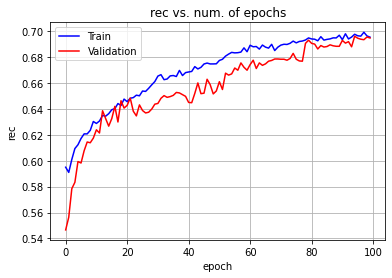

In [176]:
plot_epoch_metric(history, 'rec')

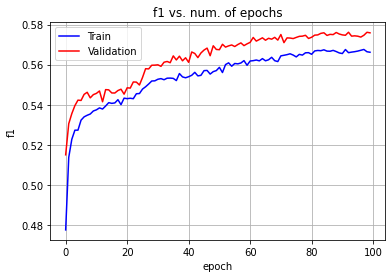

In [177]:

plot_epoch_metric(history, 'f1')

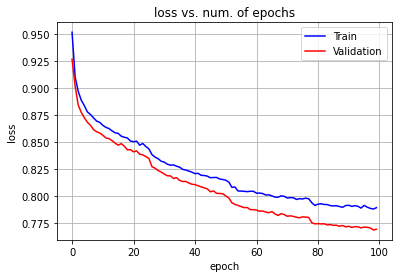

In [178]:
plot_epoch_metric(history, 'loss')

**Evaluate model on test set**

In [180]:
nn_test_metrics, nn_preds = trainer.evaluate_on_test_set(X_test_, y_test_)

In [181]:
nn_test_metrics

{'loss': 1.0092950761318207,
 'acc': 0.7368333333333333,
 'rec': 0.6322532027128862,
 'pre': 0.4347150259067358,
 'f1': 0.5151980350015352,
 'rocauc': 0.6993921695139437}

**Add Neural Network Classifier to the precision-recall curve**

Only the LGBM model shown to make the figure more readable.

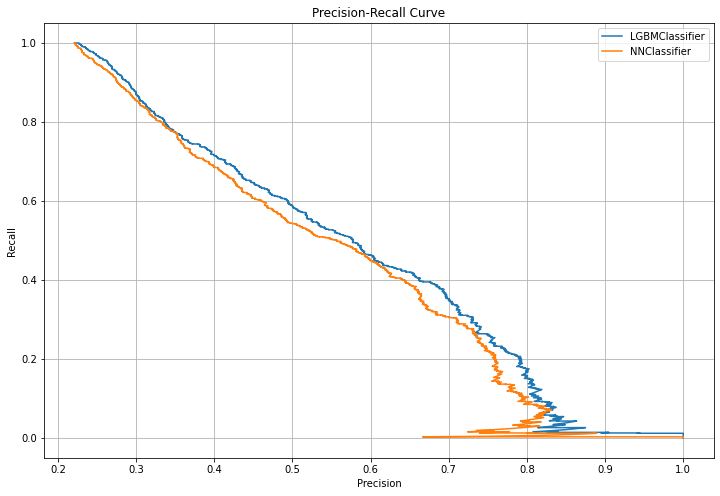

In [182]:
# Add NN Classifier to the precision-recall curve figure
pre_NN, rec_NN, th_NN = precision_recall_curve(y_test_, nn_preds)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(pre_LG, rec_LG, label='LGBMClassifier')
ax.plot(pre_NN, rec_NN, label='NNClassifier')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.legend()
ax.grid()

* **The Neural Network is not able to compete even against the LGBM, which was the worst of the three tree-based classifiers.** At any level of recall, LGBM provides more precision.

In [183]:
# Get threshold value for 80% recall
idx = closest_value_idx(rec_NN, 0.8)
th_adj_nn = th_NN[idx]

In [184]:
# Add NNClassifier to the metrics
metrics_adj_all = add_to_metrics(nn_preds, 'NNClassifier', metrics_adj_ens, th_adj_nn)
metrics_adj_all

,accuracy,recall,precision,f1_score,roc_auc
NULL,0.7788,0.0,0.0,0.0,0.5000
RandomForestClassifier,0.6272,0.8011,0.3501,0.4873,0.6894
XGBClassifier,0.6195,0.8011,0.3449,0.4822,0.6845
LGBMClassifier,0.6058,0.8011,0.336,0.4734,0.6757
EnsembleMeanProba,0.6255,0.8003,0.3489,0.4859,0.6881
NNClassifier,0.5985,0.8003,0.3313,0.4686,0.6707


* The table confirms the inferences made on the basis of the precision-recall curve. Even when the recall rate is fixed at the 80% level, the Neural Network classifier loses to the tree-based methods on every metric.

* Thus, in this investigation, **the mean-probability based Ensemble Model is the recommended classifier for predicting defaults**